In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
import joblib
import os

warnings.filterwarnings("ignore")

# ===== CONFIG =====
DATA_PATH = "/content/drive/MyDrive/codes/nse_cleaned.csv"

# ===== LOAD NSE CLEANED DATA =====
df = pd.read_csv(DATA_PATH)

# ===== PREPROCESS =====
df.columns = df.columns.str.strip()  # Remove spaces in column names
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by=['symbol', 'date'])

numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'deliverable_volume']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(method='ffill')

# ===== FEATURE ENGINEERING =====
df['MA5'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=5).mean())
df['MA10'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=10).mean())
df = df.dropna()


# ===== SYMBOL SELECTION =====
symbols = df['symbol'].unique().tolist()
print("Available Symbols:", symbols)
selected_symbol = input("Enter a symbol from above: ").strip().upper()

if selected_symbol not in symbols:
    raise ValueError("Invalid symbol selected!")

stock_df = df[df['symbol'] == selected_symbol].copy()

# ===== MODEL TRAINING =====
features = ['open', 'high', 'low', 'volume', 'deliverable_volume', 'MA5', 'MA10']
target = 'close'

X = stock_df[features]
y = stock_df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# ===== SAVE MODEL AND SCALER WITH SYMBOL NAME =====
model_filename = f"xgb_model_{selected_symbol}.pkl"
scaler_filename = f"scaler_{selected_symbol}.pkl"

joblib.dump(model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"\n✅ Model saved as {model_filename}")
print(f"✅ Scaler saved as {scaler_filename}")

# ===== PREDICTION =====
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Model Performance for {selected_symbol}:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# ===== LAST PREDICTION =====
latest_features = X_scaled[-1].reshape(1, -1)
predicted_close = model.predict(latest_features)[0]
actual_close = y.iloc[-1]

print(f"\n📅 Latest Date: {stock_df['date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"✅ Actual Close: {actual_close:.2f}")
print(f"🔮 Predicted Next Close: {predicted_close:.2f}")


Available Symbols: ['20MICRONS', '21STCENMGM', '3IINFOTECH', '3MINDIA', '3PLAND', '5PAISA', '63MOONS', '8KMILES', 'A2ZINFRA', 'AAKASH', 'AARON', 'AARTIDRUGS', 'AARTIIND', 'AARTISURF', 'AARVEEDEN', 'AARVI', 'AAVAS', 'ABAN', 'ABB', 'ABBOTINDIA', 'ABCAPITAL', 'ABFRL', 'ABMINTLTD', 'ACC', 'ACCELYA', 'ACCURACY', 'ACE', 'ADANIENT', 'ADANIGAS', 'ADANIGREEN', 'ADANIPORTS', 'ADANIPOWER', 'ADANITRANS', 'ADFFOODS', 'ADHUNIKIND', 'ADI', 'ADLABS', 'ADORWELD', 'ADROITINFO', 'ADSL', 'ADVANIHOTR', 'ADVENZYMES', 'AEGISCHEM', 'AFFLE', 'AFL', 'AGARIND', 'AGCNET', 'AGRITECH', 'AGROPHOS', 'AHLEAST', 'AHLUCONT', 'AHLWEST', 'AIAENG', 'AIONJSW', 'AIRAN', 'AJANTPHARM', 'AJMERA', 'AKASH', 'AKSHARCHEM', 'AKSHOPTFBR', 'AKZOINDIA', 'ALANKIT', 'ALBERTDAVD', 'ALCHEM', 'ALEMBICLTD', 'ALICON', 'ALKALI', 'ALKEM', 'ALKYLAMINE', 'ALLCARGO', 'ALLSEC', 'ALMONDZ', 'ALOKINDS', 'ALPA', 'ALPHAGEO', 'ALPSINDUS', 'AMARAJABAT', 'AMBER', 'AMBIKCO', 'AMBUJACEM', 'AMDIND', 'AMJLAND', 'AMRUTANJAN', 'ANANDAMRUB', 'ANANTRAJ', 'ANDHRACE

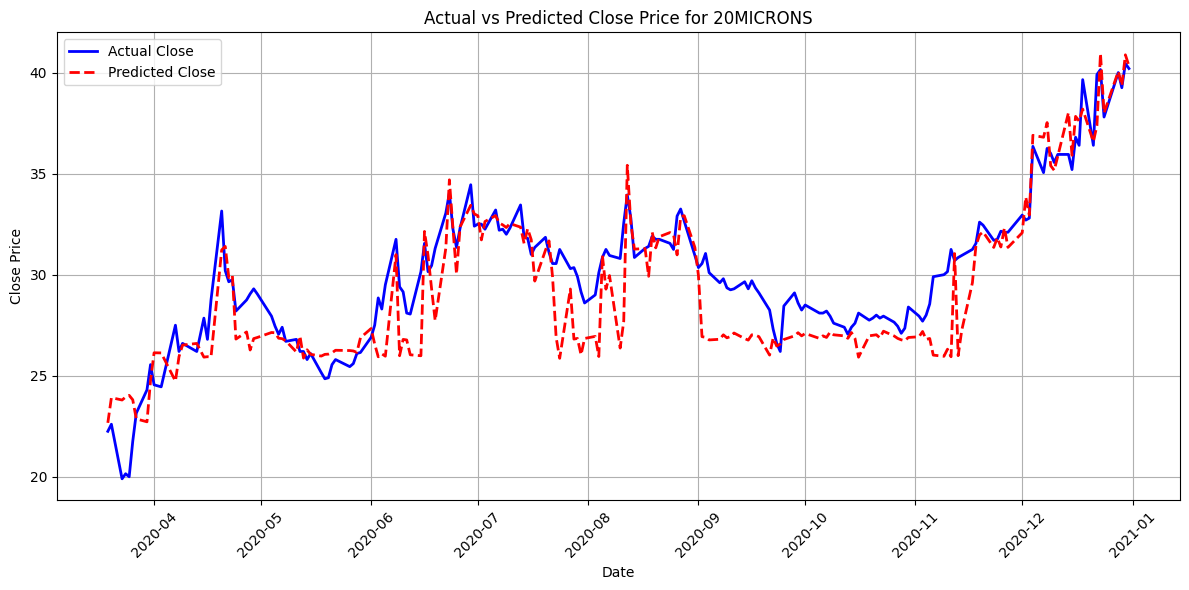

In [ ]:
import matplotlib.pyplot as plt
dates_test = stock_df['date'].iloc[-len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Close', color='blue', linewidth=2)
plt.plot(dates_test, y_pred, label='Predicted Close', color='red', linestyle='--', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f"Actual vs Predicted Close Price for {selected_symbol}")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()